In [1]:
import sys
sys.path.insert(0, '../')
import torch
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
from torch.utils.data import DataLoader, TensorDataset
from unet.model import GeneralUNet
from utils.data_utils import BratsDataset3D
import numpy as np

In [2]:
### PARAMETERS
num_epochs = 10
lr = 0.001
batch_size = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dir = r'C:\Users\johns\OneDrive\Desktop\Datasets\ECE-542\brain-tumor-segmentation(nii)\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'

In [3]:
train_dataset = BratsDataset3D(train_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Model setup
model = GeneralUNet(in_channels=4,  # Adjust based on your dataset's specifics
                    conv_kernel_size=3,
                    pool_kernel_size=2,
                    up_kernel_size=2,
                    dropout=0.1,
                    conv_stride=1,
                    conv_padding=1,
                    conv3d=True,
                    size=2,  # Adjust the number of layers in the UNet
                    complex=4)  # Adjust the complexity or number of initial features

In [5]:
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total Parameters: {total_params}')
print(f'Trainable Parameters: {trainable_params}')

GeneralUNet(
  (encoder_series): EncoderUNet(
    (blocks): ModuleList(
      (0): EncoderBlock(
        (doubleConv): ConvDouble(
          (doubleLayer): Sequential(
            (0): ConvSingle(
              (layer): Sequential(
                (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): Dropout3d(p=0.1, inplace=False)
              )
            )
            (1): ConvSingle(
              (layer): Sequential(
                (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
                (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU(inplace=True)
                (3): Dropout3d(p=0.1, inplace=False)
              )
            )
          )
        )
        (maxPool): MaxPool3d(kernel_size=2, stri

In [6]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
model = model.to(device)
torch.cuda.empty_cache()

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    loss_list = []

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        print(f'loss is: {loss}')
        loss_list.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

print("Training complete!")

print(f'Loss over time is: {loss_list}')


loss is: 0.8144641518592834
loss is: 0.7861779928207397
loss is: 0.7934949398040771
loss is: 0.7533349990844727
loss is: 0.7674343585968018
loss is: 0.7521295547485352
loss is: 0.7267768979072571
loss is: 0.7230514883995056
loss is: 0.7700076103210449
loss is: 0.732294499874115
loss is: 0.7319377660751343
loss is: 0.708748996257782
loss is: 0.717416524887085
loss is: 0.6966854929924011
loss is: 0.7129519581794739
loss is: 0.6767493486404419
loss is: 0.7218191623687744
loss is: 0.7164386510848999
loss is: 0.6916707158088684
loss is: 0.6718206405639648
loss is: 0.7215173244476318
loss is: 0.6636384129524231
loss is: 0.699781060218811
loss is: 0.6827631592750549
loss is: 0.7127849459648132
loss is: 0.6660985350608826
loss is: 0.6731115579605103
loss is: 0.6592053771018982
loss is: 0.6782952547073364
loss is: 0.6686820387840271
loss is: 0.6876596808433533
loss is: 0.6508073806762695
loss is: 0.6480321884155273
loss is: 0.6781135201454163
loss is: 0.6369509696960449
loss is: 0.6753413677215

In [8]:
loss_values = [loss_item.cpu().item() for loss_item in loss_list]

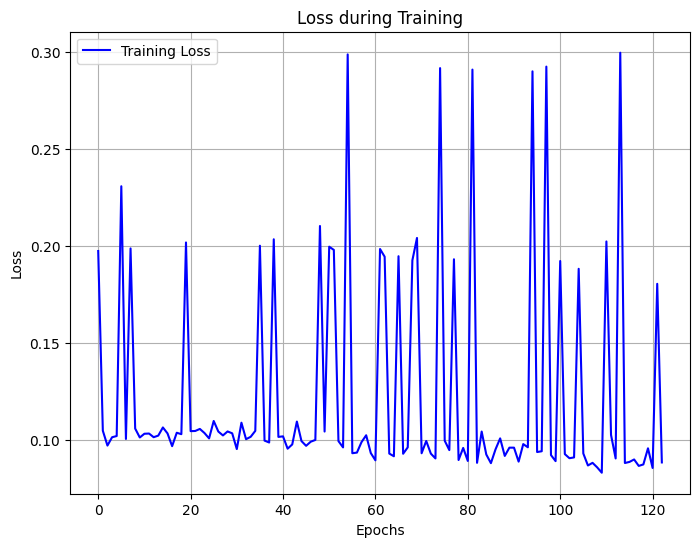

In [9]:
import matplotlib.pyplot as plt
import torch
# Convert the CUDA tensor to a CPU tensor and then to a NumPy array

# Plotting the loss list
plt.figure(figsize=[8,6])  # You can adjust the size of the figure
plt.plot(loss_values, label='Training Loss', color='blue')  # You can change the label and color
plt.title('Loss during Training')  # Title of the plot
plt.xlabel('Epochs')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

In [11]:
torch.save(model, r"C:\Users\johns\OneDrive\Desktop\Models\ECE542_Project_Brain_Segmentation\20K_model_10_epochs.pth")
